In [17]:
# import and config
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
from pathlib import Path
from os import getcwd, listdir, path
import os 
import scipy.io
import warnings
from typing import Dict, Generic
from sklearn import preprocessing
from typing import TypeVar
import PyQt5


warnings.filterwarnings('ignore')
# %matplotlib qt

%cd "/home/matej/2-fer/uuzop/projekt"

UNZIP_DATA = False

PATH_CWD = Path(getcwd()) 

PATH_DATA = Path(PATH_CWD, "data")
PATH_DATA_MAT = Path(PATH_DATA, "mat")
PATH_DATA_CNT = Path(PATH_DATA, "cnt")

PATH_ZIP_CNT = Path(PATH_DATA, "5202739.zip")
PATH_ZIP_MAT = Path(PATH_DATA, "5202751.zip")



/home/matej/2-fer/uuzop/projekt


In [18]:
# Abstractions
T = TypeVar('T') #Any

In [19]:
# CNT - unzip and restructure data
if  UNZIP_DATA:
    with ZipFile(PATH_ZIP_CNT, 'r') as zip_ref:
        zip_ref.extractall(PATH_DATA_CNT)
    
    zips = [file for file in PATH_DATA_CNT.iterdir() if str(file).endswith(".zip")]
    
    for zip_item in zips:
        
        if not str(zip_item).endswith(".zip"):
            continue
        
        zip_ref = ZipFile(zip_item) # create zipfile object
        
        for cnt_file in zip_ref.namelist()[1:]: # ignore "9/" directory
        
            prefix_number = zip_item.stem # 9
            state_name = Path(cnt_file).stem.lower().split(' ')[0] # "Normal State" -> "normal"
            filename = Path(prefix_number + '_' + state_name + ".cnt")
            
            with open(Path(PATH_DATA_CNT, filename), "wb") as new_file:
                new_file.write(zip_ref.read(cnt_file))
                
    # Delete zips as they were temporary
    for zip_item in zips:
    	os.remove(zip_item)

In [20]:
# MAT - unzip data
if  UNZIP_DATA:
    with ZipFile(PATH_ZIP_MAT, 'r') as zip_ref:
        zip_ref.extractall(PATH_DATA_MAT)

In [30]:
mat = scipy.io.loadmat(Path(PATH_DATA_MAT, '1.mat'))
keys = [key for key in mat.keys() if not key.startswith('__')]

[print(key, "with shape",mat[key].shape) for key in keys]

is_normal_state_mask = pd.Series(mat["Class_label"].squeeze() == 0)
keys_entropy = ["FE", "SE", "AE", "PE"]

entropies: Dict[str,pd.DataFrame]={}
for key in keys_entropy:
    entropies[key] = pd.DataFrame(mat[key])
    print(key, "\n",entropies[key].describe()) 
      


FE with shape (300, 30)
SE with shape (300, 30)
AE with shape (300, 30)
PE with shape (300, 30)
Class_label with shape (300, 1)
0      False
1      False
2      False
3      False
4      False
       ...  
295     True
296     True
297     True
298     True
299     True
Length: 300, dtype: bool
FE 
                0           1           2           3           4           5   \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.431359    0.563979    0.417747    0.493588    0.414482    0.694414   
std      0.248203    0.305999    0.245915    0.097227    0.107826    0.060513   
min      0.121665    0.145772    0.124204    0.342008    0.224410    0.609064   
25%      0.180654    0.257208    0.184079    0.416103    0.304050    0.655356   
50%      0.482518    0.610600    0.396680    0.464015    0.426226    0.671115   
75%      0.662479    0.866264    0.616511    0.562170    0.508063    0.705368   
max      0.883251    1.052312    0.945170    0.7533

In [22]:
        
def dict_apply_procedture(old_dict: Dict[str, T], procedure) -> Dict[str, T]:
    return {k: procedure(v) for k, v in old_dict.items()}
    
def min_max_dataframe(df: pd.DataFrame):
    return pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df))

def standard_scale_dataframe(df: pd.DataFrame):
    return pd.DataFrame(preprocessing.StandardScaler().fit_transform(df))

fig = plt.figure(figsize=(20,20), tight_layout={"h_pad": 2})

ax = fig.add_subplot(3,1, 1)
for name, entropy in entropies.items():
    ax.set_title("Original")
    ax.scatter(entropy.index.tolist(), entropy.loc[:,1],  label=name)
    ax.legend()

entropies_scaled = dict_apply_procedture(entropies, min_max_dataframe)
ax = fig.add_subplot(3,1, 2)
for name, entropy in entropies_scaled.items():
    ax.set_title("Min_max")
    ax.scatter(entropy.index.tolist(), entropy.loc[:,1],  label=name)
    ax.legend()
    
entropies_scaled_2 = dict_apply_procedture(entropies, standard_scale_dataframe)
ax = fig.add_subplot(3,1, 3)
for name, entropy in entropies_scaled_2.items():
    ax.set_title("Standard scaler")
    ax.scatter(entropy.index.tolist(), entropy.loc[:,1],  label=name)
    ax.legend()
    



In [23]:
# Null and NaN are the same in Pandas :)

def isnull_any(df):
    return df.isnull().any()

def isnull_values_sum(df):
    return df.isnull().values.sum() > 0

def isnull_sum(df):
    return df.isnull().sum() > 0

def isnull_values_any(df):
    return df.isnull().values.any()

def rows_with_null(df):
    return df[df.isnull().any(axis=1)]

for name, entropy in entropies_scaled.items():
    if (isnull_values_any(entropy)):
        print("Entropy", name, "has null values")
    if (isnull_values_any(entropy)):
        print("Entropy", name, "has null values")

<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
[[ 7.32635240e-04  1.65638180e-05  7.35207651e-04 ...  3.53549677e-04
   1.10946210e-03  3.58819983e-04]
 [-2.50966940e-07 -3.76450410e-07 -2.50966940e-07 ... -3.76450410e-07
  -2.50966940e-07 -3.76450410e-07]
 [ 0.00000000e+00 -5.22073977e-04  0.00000000e+00 ... -3.54365319e-04
   0.00000000e+00 -3.53235968e-04]
 ...
 [-3.13708675e-07  0.00000000e+00 -3.13708675e-07 ...  0.00000000e+00
  -3.13708675e-07  0.00000000e+00]
 [ 2.86478762e-04  0.00000000e+00  2.73365739e-04 ...  0.00000000e+00
   3.83226517e-04  0.00000000e+00]
 [-2.50966940e-07  0.00000000e+00 -2.50966940e-07 ...  0.00000000e+00
  -2.50966940e-07  0.00000000e+00]]
Effective window size : 1.001 (s)


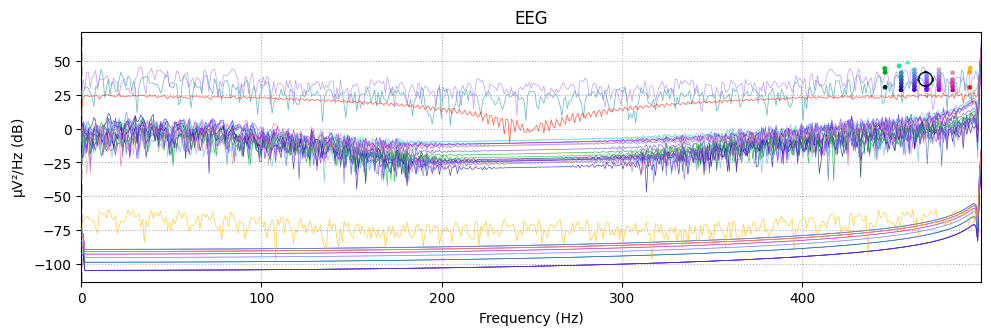

In [9]:
# mne signal processing
# sample_data_folder = mne.datasets.sample.data_path()
# sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
#                                     'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_cnt(str(Path(PATH_DATA_CNT, "1_fatigue.cnt")))
print(raw.info)
print(raw.get_data())
# ica = mne.preprocessing.ICA(n_components=2, random_state=97, max_iter=800)

# ica.fit(raw)
# ica.exclude = [1, 2]  # details on how we picked these are omitted here
# ica.plot_properties(raw, picks=ica.exclude)
# raw.plot()
raw.plot_psd(fmin=0,tmin=0, tmax=1,  exclude=['FT8'])
# raw.plot(duration=5, )
